# Data Exploreatory 

Part I

in this notebook following actions will be taken 

* the ration of the benign and malicious traffic in the dataset 

* ratio of every attack in the dataset

* correlation between the features

* correlation between the net features and the bening label 

In [1]:
#!pip install missingno

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy import stats
from scipy.stats import ks_2samp

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/upm/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Processed dataset loaded to the dataframe 

In [3]:
# base path to the dataset files 
path = r"/media/upm/New Volume/project/0/processed"

In [4]:
# declear the new features types so we can load them to the df later
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

In [5]:
# merge all dataset files in one DF using glob
csvs = glob.glob(os.path.join(path, '*.csv'))

df = pd.concat((pd.read_csv(f, dtype=types) for f in csvs))

# 1- check for all missing values 

### "inf" values changed to "nan" after identifying the targeted columns 

In [6]:
# check and identify all dataset coulmns for inf string using numpy
inf_col = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]

In [7]:
# print the coulmns that has infinity values
print(f' infinity values {inf_col}')

 infinity values ['flow_byts_s', 'flow_pkts_s']


In [8]:
# replace inf with nan 
for col in inf_col:
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    mean = df[col].mean()
    df[col].fillna(mean, inplace=True)

# 2- label creating 

two labels one for binary class (benign and malicious) and the other for multiclass

- attack_label > binary classes
- label_is_attack[attack_type] > multi-classes

In [9]:
# cast label to the type category
df['label'] = df.label.astype('category')
df['label_code'] = df['label'].cat.codes # create a series of codes in label_code with respect to the label col
df['label_is_attack'] = df.label.apply(lambda x: 0 if x == 'Benign' else 1) # use lambda fumction to assign 0 for bening and 1 for attack
df['binay_classes'] = df.label.apply(lambda x: 'Benign' if x == 'Benign' else 'attack')

In [10]:
# create multi-class labels for attacks 
attack_types = [a for a in df.label.value_counts().index.tolist() if a != 'Benign']

for a in attack_types:
    l = 'label_is_attack_' + a.replace('-', ' ').replace(' ', '_').lower()
    df[l] = df.label.apply(lambda x: 1 if x == a else 0)

# 3- dataset overview

In [11]:
df.info(verbose=True, null_counts=True)

<ipython-input-11-6ac79f7ef903>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose=True, null_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16232943 entries, 0 to 613070
Data columns (total 97 columns):
 #   Column                                    Non-Null Count     Dtype   
---  ------                                    --------------     -----   
 0   dst_port                                  16232943 non-null  uint32  
 1   protocol                                  16232943 non-null  uint8   
 2   timestamp                                 16232943 non-null  object  
 3   flow_duration                             16232943 non-null  int64   
 4   tot_fwd_pkts                              16232943 non-null  uint32  
 5   tot_bwd_pkts                              16232943 non-null  uint32  
 6   totlen_fwd_pkts                           16232943 non-null  uint32  
 7   totlen_bwd_pkts                           16232943 non-null  uint32  
 8   fwd_pkt_len_max                           16232943 non-null  uint16  
 9   fwd_pkt_len_min                           16232943 non-nu

# 4- relation between bengin and malicious network flow 

plot the ratio between the malicious and benign traffic 

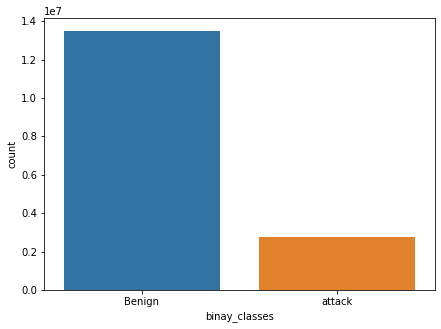

In [12]:
# plot ratio

f, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x='binay_classes', data=df, order = df['binay_classes'].value_counts().index, ax=ax)

In [13]:
# percentage of both traffic in the dataset

df_is_attack = df.groupby('binay_classes').agg({'binay_classes':'first', 'binay_classes':'count'}).rename_axis(None).sort_values('binay_classes', ascending=False)
df_is_attack['percentage'] = df_is_attack / df_is_attack.loc[:'binay_classes'].sum()

df_is_attack

,binay_classes,percentage
Benign,13484708,0.8307
attack,2748235,0.1693


# 5- Flow per attack type

The following graph shows the number of flows accounting for the different attack types.

following list of attacks are few with the respect to the other types

* DoS attacks-GoldenEye

* DoS attacks-Slowloris

* DDOS attack-LOIC-UDP

* Brute Force-Web

* Brute Force-XSS

* SQL Injection

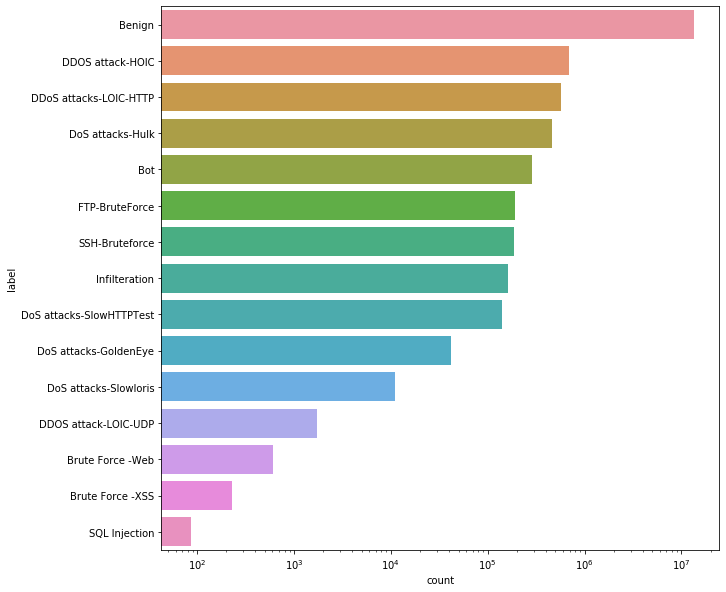

In [14]:
f, ax = plt.subplots(figsize=(10, 10)) # determin figure size 
ax.set(xscale='log')
# from seaborn identify label as y and dataset is df 
sns.countplot(y='label', data=df, order = df['label'].value_counts().index, ax=ax)

In [15]:
# group all attack types by thier label and flow number for eatch attack
df.groupby('label').agg({'label':'first', 'label':'count'}).rename_axis(None).sort_values('label', ascending=False)

,label
Benign,13484708
DDOS attack-HOIC,686012
DDoS attacks-LOIC-HTTP,576191
DoS attacks-Hulk,461912
Bot,286191
FTP-BruteForce,193360
SSH-Bruteforce,187589
Infilteration,161934
DoS attacks-SlowHTTPTest,139890
DoS attacks-GoldenEye,41508


## 6- Feature Correlations


we use heatmap to show the correlations for a number of feature-pairs.

with each other 


In [16]:
# create corr var for creatin the heatmap without "label" and "timestamp" cols
corr = df.drop(columns=['label', 'timestamp' , 'binay_classes']).corr()

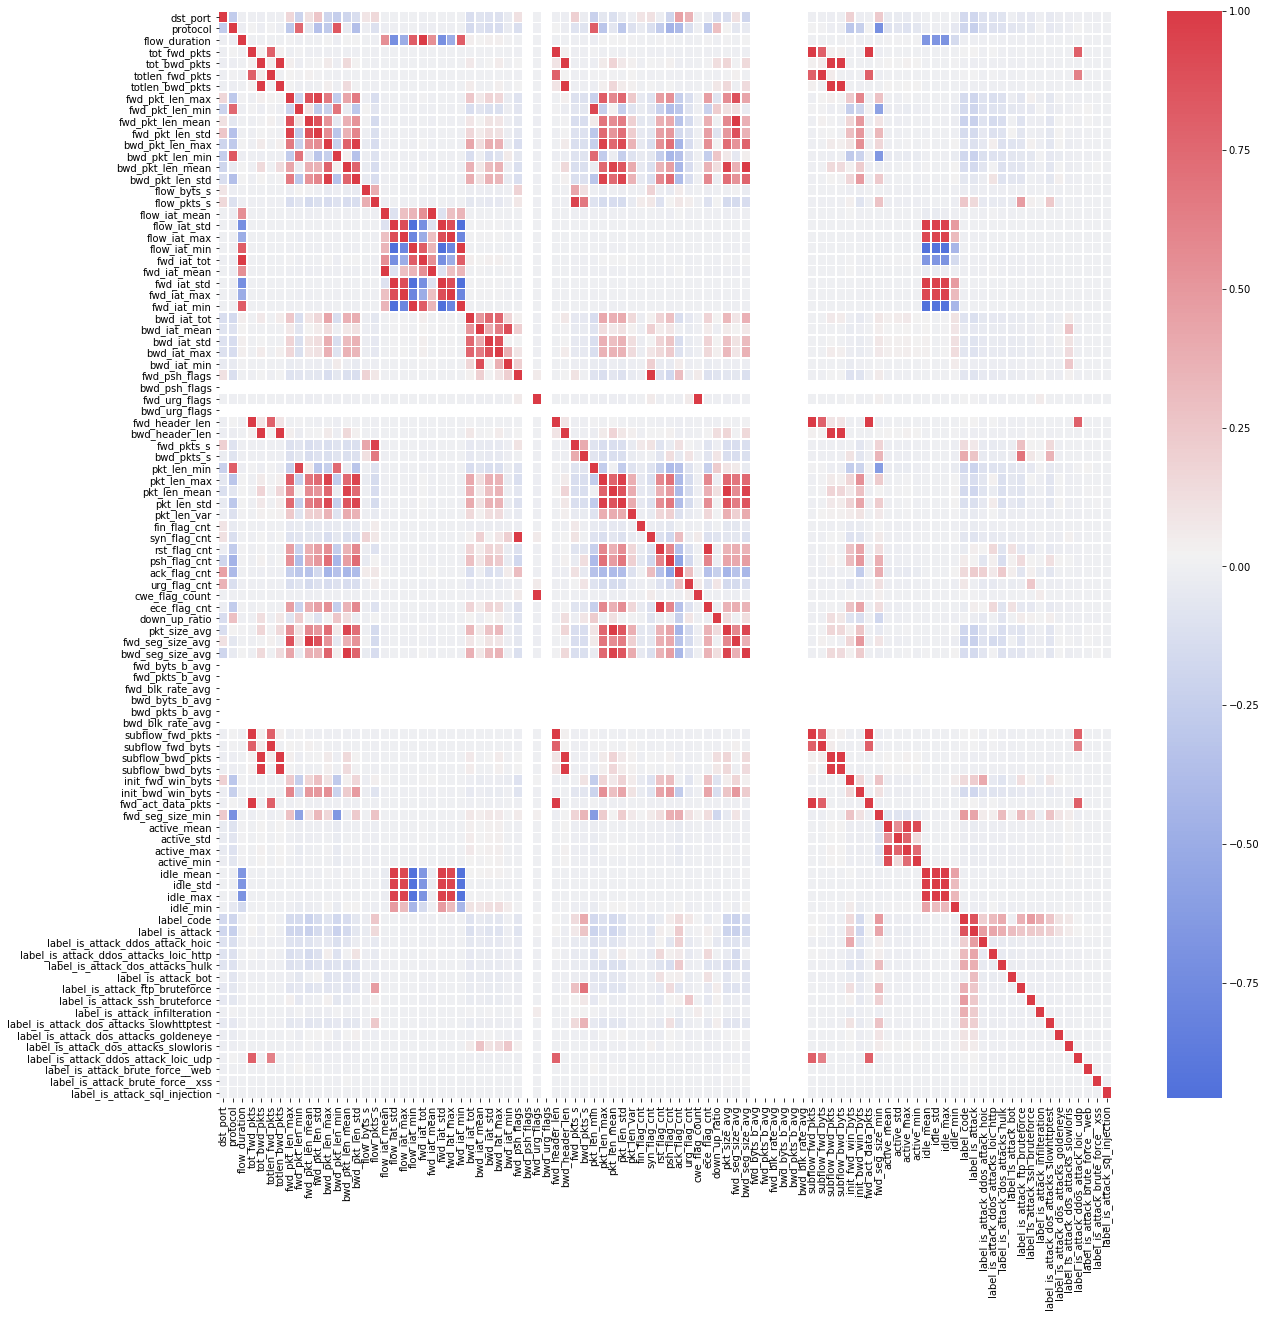

In [17]:
#correlation between all the features and eatch other 

plt.figure(figsize=(20, 20))

sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns, linewidths=.5, 
           cmap=sns.diverging_palette(620, 10, as_cmap=True))

In [20]:
# define strong correlations features with trshold 0.8 "with each other"

def get_abs_correlations(df, t):
    labels_to_drop = set()
    cols = df.columns.drop(['label', 'timestamp' , 'binay_classes'])
    for i in range(0, df.shape[1]-3):
        for j in range(0, i+1):
            labels_to_drop.add((cols[i], cols[j]))
    
    c = corr.abs().unstack().drop(labels=labels_to_drop).sort_values(ascending=False)
    return c[c > t]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(get_abs_correlations(df, 0.8))

fwd_urg_flags     cwe_flag_count       1.000000
totlen_fwd_pkts   subflow_fwd_byts     1.000000
fwd_pkt_len_mean  fwd_seg_size_avg     1.000000
bwd_pkt_len_mean  bwd_seg_size_avg     1.000000
tot_bwd_pkts      subflow_bwd_pkts     1.000000
tot_fwd_pkts      subflow_fwd_pkts     1.000000
fwd_psh_flags     syn_flag_cnt         1.000000
totlen_bwd_pkts   subflow_bwd_byts     1.000000
flow_iat_min      fwd_iat_min          0.999996
flow_iat_max      fwd_iat_max          0.999994
rst_flag_cnt      ece_flag_cnt         0.999987
flow_duration     fwd_iat_tot          0.999986
flow_iat_std      fwd_iat_std          0.999981
flow_iat_mean     fwd_iat_mean         0.999963
subflow_fwd_pkts  fwd_act_data_pkts    0.999189
tot_fwd_pkts      fwd_act_data_pkts    0.999189
tot_bwd_pkts      bwd_header_len       0.997798
bwd_header_len    subflow_bwd_pkts     0.997798
                  subflow_bwd_byts     0.996040
totlen_bwd_pkts   bwd_header_len       0.996038
fwd_header_len    subflow_fwd_pkts     0

## 7- Features having a correlation with the binary class of network flows

In the next step features correlating to the binary attack label are identified. The features with the highest correlations are analyzed via their basic statistics and distribution to evaluate if those features might be relevant in predicting the label of the network flow.

In [21]:
# filitier word label and just look for the corealtion in respect to the binary class features
corr_is_attack = corr.label_is_attack.filter(regex=r'^(?!label).*', axis=0)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(corr_is_attack[corr_is_attack.notnull()].sort_values(ascending=False)[:5])

fwd_seg_size_min     0.429296
bwd_pkts_s           0.260203
ack_flag_cnt         0.220465
init_fwd_win_byts    0.218390
flow_pkts_s          0.148600
Name: label_is_attack, dtype: float64


## Features having a correlation with the multi-class of network flows

In the next step features correlating to the binary attack label are identified. 

In [22]:
# filitier word label and just look for the corealtion in respect to the binary class features
#corr_is_attack = corr.label_is_attack


#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
 #   print(corr_is_attack[corr_is_attack.notnull()].sort_values(ascending=False)[:20])

# 8- statistical visualization

* remove outliers

* plot box 

* plot distribution

* distribution_similarit

basic statistics and distribution to evaluate if those features might be relevant in predicting the label of the network flow.


## following features correlates with binary class :

* Minimum segment size observed in the forward direction (`fwd_seg_size_min`)
* Number of backward packets per second (`bwd_pkts_s`)
* Number of packets with ACK flag (`ack_flag_cnt`)
* Minimum size of packet in backward direction (`bwd_pkt_len_min`)

In [23]:
def remove_outliers(data, col, zscore_thres=3):
    return data[(np.abs(stats.zscore(data[[col]])) < zscore_thres).all(axis=1)]


def plot(fn, height, data, label, col, scale='', with_outliers=True, xlim=[], bins=10):
    fig, ax = plt.subplots(figsize=(18, height))
    d = data if with_outliers else remove_outliers(data, col)
    if xlim:
        ax.set_xlim(xlim)
    if scale:
        ax.set(xscale=scale)
    fn(d, label, col, ax, bins)
    plt.show()

    
def plot_box(data, label, col, scale='', with_outliers=True, xlim=[]):
    plot(lambda d, l, c, ax, b: sns.boxplot(y=l, x=c, data=d, ax=ax, orient='h', width=0.4), 2, data, label, col, scale, with_outliers, xlim)
    
    
def plot_distribution(data, label, col, scale='', with_outliers=True, xlim=[], bins=10):
    plot(lambda d, l, c, ax, b: d.groupby(l)[c].plot.hist(density=True, ax=ax, alpha=0.5, bins=b), 5, data, label, col, scale, with_outliers, xlim, bins)
    
    
def plot_stats(data, label, col, no_outliers=False):
    print(data.groupby(label)[col].describe())
    plot_box(data, label, col)
    
    
def calculate_distribution_similarity(data, label, col):

    a = data[data[label] == 0][col]
    b = data[data[label] == 1][col]
    return ks_2samp(a, b)

In [24]:
df['Binary'] = df.label.apply(lambda x: 0 if x == 'Benign' else 1)

## 8.1 - Minimum segment size observed in the forward direction

`fwd_seg_size_min` might be a good predictor as the distributions of the feature for each of the classes differ significantly and the p-value for the hypothesis that values from both classes originate from the same distribution is 0.

             count       mean       std  min   25%   50%   75%   max
Binary                                                              
0       13484708.0  16.501569  6.757963  0.0   8.0  20.0  20.0  56.0
1        2748235.0  25.309007  7.817982  0.0  20.0  20.0  32.0  40.0


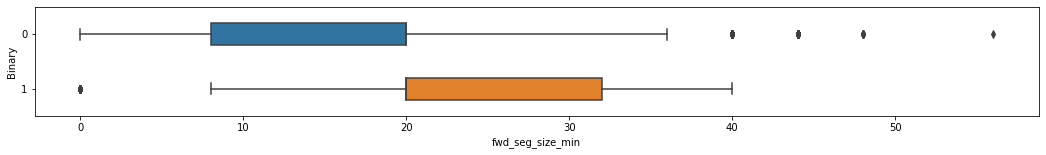

In [25]:
plot_stats(df, 'Binary', 'fwd_seg_size_min')

In [26]:
calculate_distribution_similarity(df, 'Binary', 'fwd_seg_size_min')

KstestResult(statistic=0.3423301956292818, pvalue=0.0)

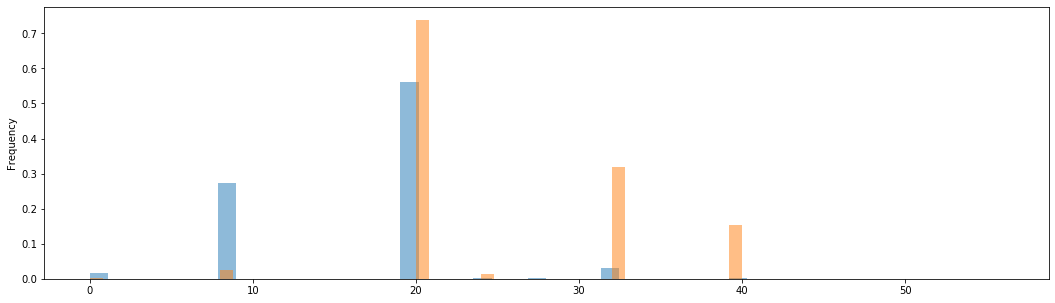

In [27]:
plot_distribution(df, 'Binary', 'fwd_seg_size_min', bins=50)

## 8.2 - Number of backward packets per second

`bwd_pkts_s` might also be a good predictor as the distributions of the feature for each of the classes differ significantly and the p-value for the hypothesis that values from both classes originate from the same distribution is 0.

             count          mean            std  min       25%      50%  \
Binary                                                                    
0       13484708.0   4408.272949   43276.777344  0.0  0.161656  4.30558   
1        2748235.0  68462.937500  200881.171875  0.0  0.000000  0.00000   

               75%        max  
Binary                         
0       882.612549  2000000.0  
1       350.877197  2000000.0  


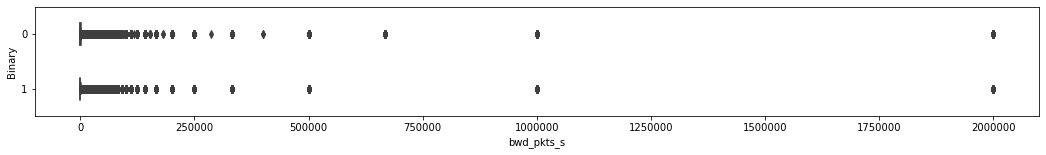

In [28]:
plot_stats(df, 'Binary', 'bwd_pkts_s')

In [29]:
calculate_distribution_similarity(df, 'Binary', 'bwd_pkts_s')

KstestResult(statistic=0.3205970312370562, pvalue=0.0)

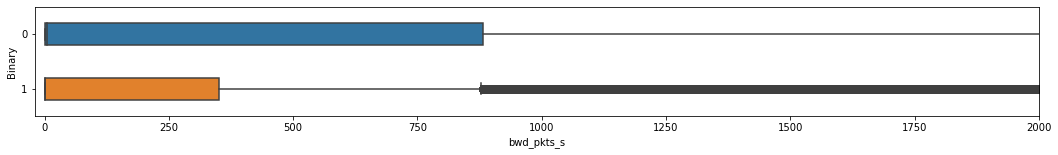

In [30]:
plot_box(df, 'Binary', 'bwd_pkts_s', xlim=[-20, 2000])

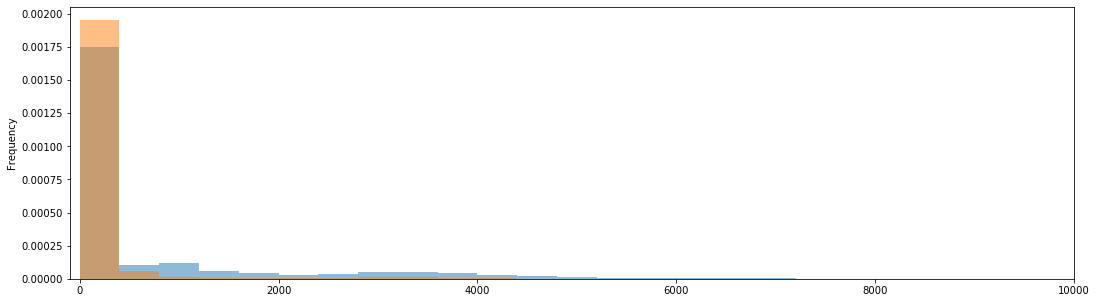

In [31]:
plot_distribution(df, 'Binary', 'bwd_pkts_s', bins=5000, xlim=[-100, 10000])

## 8.3 - Number of packets with ACK flag

`ack_flag_cnt` might also be a good predictor as the distributions of the feature for each of the classes differ significantly and the p-value for the hypothesis that values from both classes originate from the same distribution is 0.

             count      mean       std  min  25%  50%  75%  max
Binary                                                         
0       13484708.0  0.284745  0.451293  0.0  0.0  0.0  1.0  1.0
1        2748235.0  0.561513  0.496202  0.0  0.0  1.0  1.0  1.0


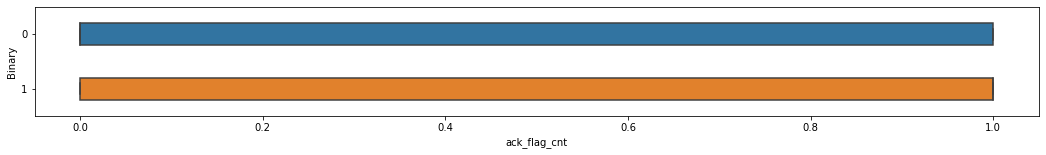

In [32]:
plot_stats(df, 'Binary', 'ack_flag_cnt')

In [33]:
calculate_distribution_similarity(df, 'Binary', 'ack_flag_cnt')

KstestResult(statistic=0.2767682713043731, pvalue=0.0)

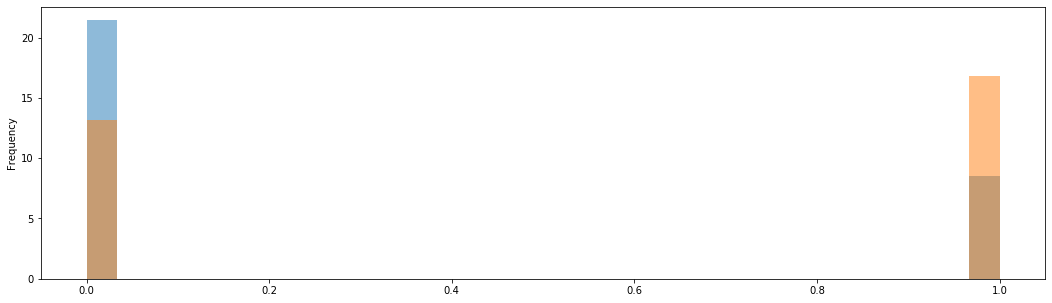

In [34]:
plot_distribution(df, 'Binary', 'ack_flag_cnt', bins=30)

## 8.4 - Minimum size of packet in backward direction

To conclude the exploration of the dataset a feature identified as a promising predictor in the [paper](https://www.scitepress.org/Papers/2018/66398/66398.pdf) accompanying the dataset is analyzed. The feature in question is the minimum size of packet in backward direction `bwd_pkt_len_min`.

             count       mean        std  min  25%  50%   75%     max
Binary                                                               
0       13484708.0  31.486992  54.162517  0.0  0.0  0.0  59.0  1460.0
1        2748235.0   1.900770  15.138823  0.0  0.0  0.0   0.0   549.0


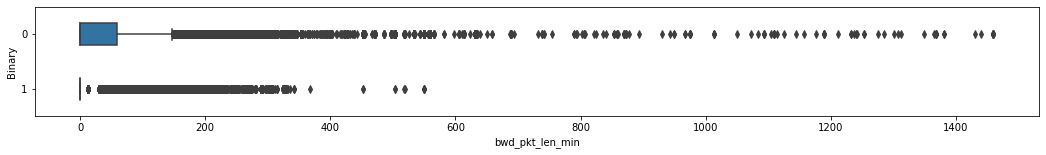

In [35]:
plot_stats(df, 'Binary', 'bwd_pkt_len_min')

In [36]:
calculate_distribution_similarity(df, 'Binary', 'bwd_pkt_len_min')

KstestResult(statistic=0.2895803001661078, pvalue=0.0)

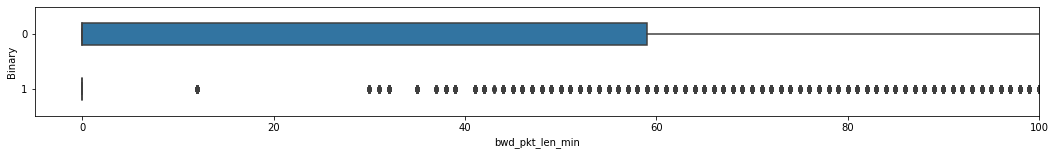

In [37]:
plot_box(df, 'Binary', 'bwd_pkt_len_min', xlim=[-5, 100])

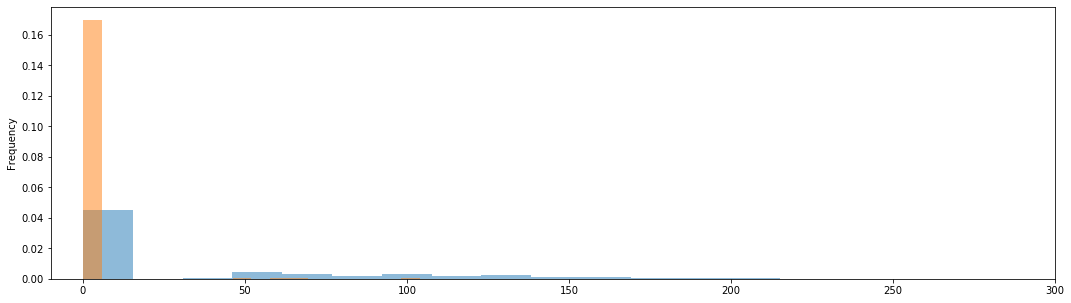

In [40]:
plot_distribution(df, 'Binary', 'bwd_pkt_len_min', bins=95, xlim=[-10, 300])

### Final observation

EDA reveled some important information about the dataset:

1. The ratio of the bengin traffic is the most represented label in the dataset

2. Some network attack isnt represented well in the dataset which make it diffcult for multiclass classfication to train the under represnted data 

3. there are a huge amount of corelated features that could be ignored and removed before establishing the training 

4. few number of features had the best wights to be good at the binry classfication phase 